# Fully Convolutional Neural Network - Signal denoising example

Learning goals:
    - Illustrate the use of a fully convolutional neural network for signal denoising.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import sys
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D,Add,MaxPooling1D, Add,  LeakyReLU

Shape: # of samples x length of samples x # of transients
(270, 256, 20)
(270, 256)


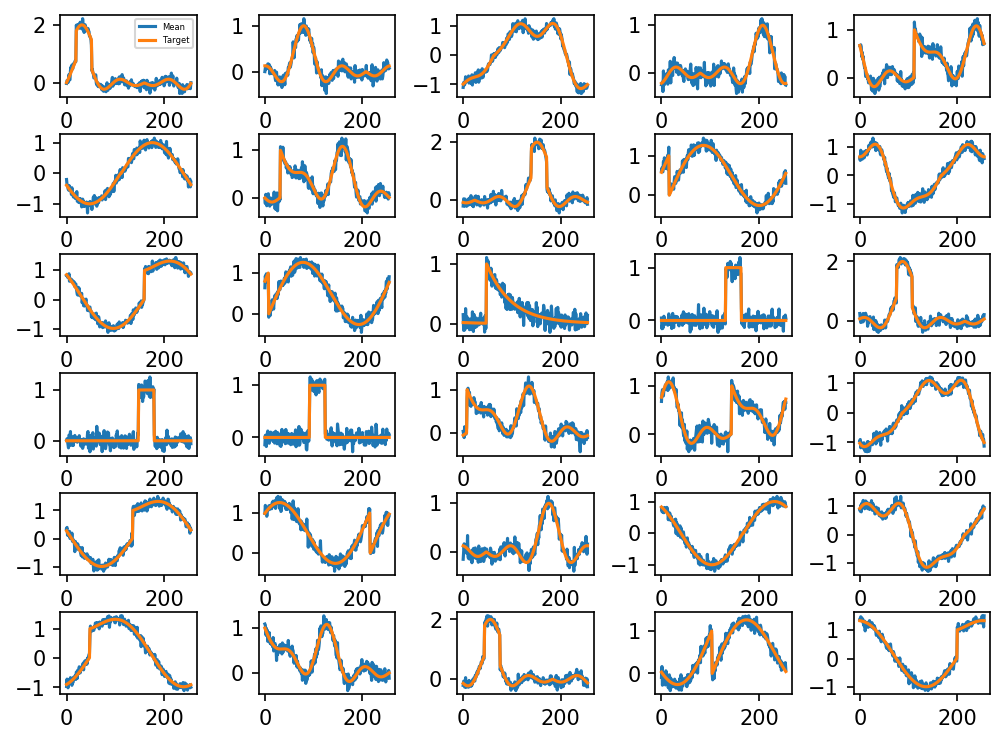

In [2]:
# Load dataset
transients = np.load("../Data/Denoiser-demo/noisy_transients.npy")
target = np.load("../Data/Denoiser-demo/reference.npy")
print("Shape: # of samples x length of samples x # of transients")
print(transients.shape)
print(target.shape)

# Displaying some samples in the dataset
plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(6, 5)
gs1.update(wspace=0.45, hspace=0.45)

for ii in range(30):
    plt.subplot(gs1[ii])
    plt.plot(transients[ii].mean(axis = -1).T,label = 'Mean')
    plt.plot(target[ii].T, label = "Target")
    if (ii == 0):
        plt.legend(fontsize = 4)
plt.show()

In [3]:
# Splitting our dataset into train/validation/test sets
split_indexes = 180,240 # Arbitrary choice here


train = transients[:split_indexes[0]]
train_target = target[:split_indexes[0]]

val = transients[split_indexes[0]:split_indexes[1]]
val_target = target[split_indexes[0]:split_indexes[1]]

test = transients[split_indexes[1]:]
test_target = target[split_indexes[1]:]


# Normalization by mean and std of train set
norm_mean = train.mean()
norm_std = train.std()

train = (train-norm_mean)/norm_std
train_target = (train_target-norm_mean)/norm_std

val = (val-norm_mean)/norm_std
val_target = (val_target-norm_mean)/norm_std

# The test target doesn't need to be normalized
test = (test-norm_mean)/norm_std

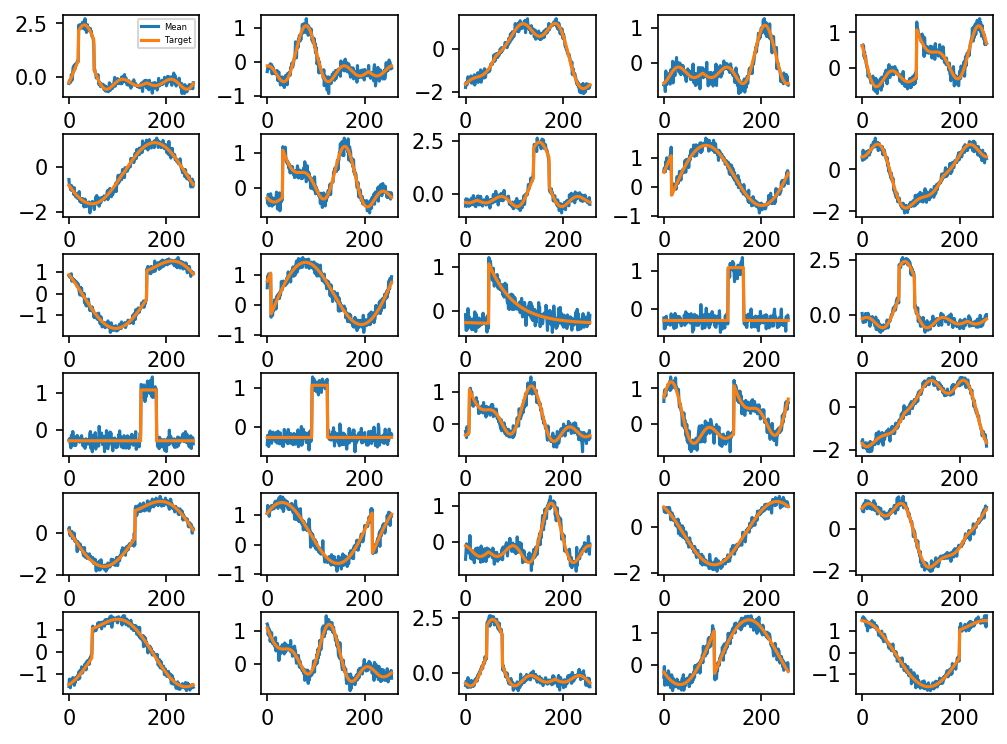

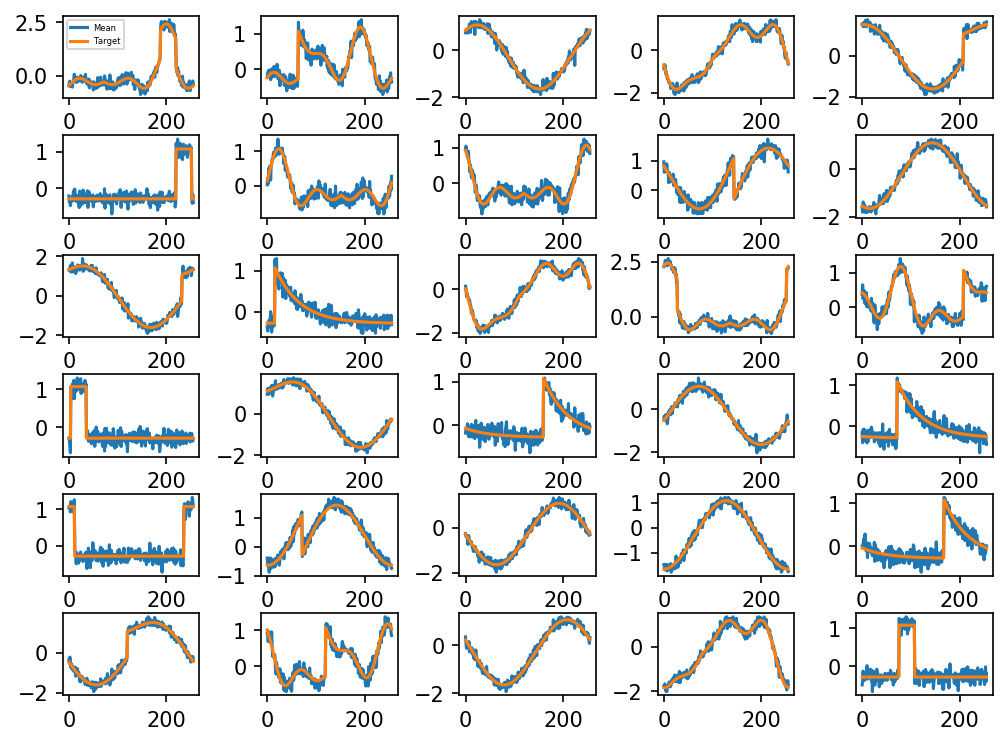

In [4]:
# Displaying some samples in the train
plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(6, 5)
gs1.update(wspace=0.45, hspace=0.45)

for ii in range(30):
    plt.subplot(gs1[ii])
    plt.plot(train[ii].mean(axis = -1).T,label = 'Mean')
    plt.plot(train_target[ii].T, label = "Target")
    if (ii == 0):
        plt.legend(fontsize = 4)
plt.show()

# Displaying some samples in the validation
plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(6, 5)
gs1.update(wspace=0.45, hspace=0.45)

for ii in range(30):
    plt.subplot(gs1[ii])
    plt.plot(val[ii].mean(axis = -1).T,label = 'Mean')
    plt.plot(val_target[ii].T, label = "Target")
    if (ii == 0):
        plt.legend(fontsize = 4)
plt.show()

In [5]:
def cnn_block(inputs,kshape= 3):
    conv1 = Conv1D(64, kshape, padding='same')(inputs)
    conv1 = LeakyReLU(alpha=0.0)(conv1)
    conv1 = Conv1D(64, kshape,  padding='same')(conv1)
    conv1 = LeakyReLU(alpha=0.0)(conv1)
    conv1 = Conv1D(64, kshape, padding='same')(conv1)
    conv1 = LeakyReLU(alpha=0.0)(conv1)
    conv1 = Conv1D(64, kshape,  padding='same')(conv1)
    conv1 = LeakyReLU(alpha=0.0)(conv1)
    conv1 = Conv1D(64, kshape, padding='same')(conv1)
    conv1 = LeakyReLU(alpha=0.0)(conv1)
    conv1 = Conv1D(64, kshape,  padding='same')(conv1)
    conv1 = LeakyReLU(alpha=0.0)(conv1)
    conv1 = Conv1D(64, kshape, padding='same')(conv1)
    conv1 = LeakyReLU(alpha=0.0)(conv1)
    out = Conv1D(1, 1, activation='linear')(conv1)
    return out


def cnn_denoiser(N = 256,kshape= 3,channels = 20):
    fids = Input(shape=(N,channels))
    noisy_spectrum = Input(shape=(N,1))
    cnn_out = cnn_block(fids,kshape= kshape)
    res = Add()([noisy_spectrum,cnn_out])
    model = Model(inputs=[fids,noisy_spectrum], outputs=[res])
    return model

In [6]:
# We are going to save our model with this name
model_name = "../Data/Models/denoiser.hdf5"
  

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                             monitor='val_loss',verbose=0,\
                             save_best_only=True, save_weights_only = True)

# Defining the model
model = cnn_denoiser(N = 256,kshape= 3,channels = 20)
print(model.summary())
opt = Adam(lr = 1e-3,decay = 1e-8)
model.compile(loss = 'mse',optimizer=opt)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 20)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 64)      3904        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 64)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 256, 64)      12352       leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [7]:
hist = model.fit([train,train.mean(axis = -1)[:,:,np.newaxis]],train_target,
                               epochs=250,
                               verbose=1,
                               validation_data= ([val,val.mean(axis = -1)[:,:,np.newaxis]],val_target),
                               callbacks=[checkpoint])

Train on 180 samples, validate on 60 samples
Epoch 1/250
180/180 [==============================] - 2s 9ms/sample - loss: 0.0185 - val_loss: 0.0169
Epoch 2/250
180/180 [==============================] - 0s 351us/sample - loss: 0.0163 - val_loss: 0.0157
Epoch 3/250
180/180 [==============================] - 0s 336us/sample - loss: 0.0144 - val_loss: 0.0116
Epoch 4/250
180/180 [==============================] - 0s 353us/sample - loss: 0.0104 - val_loss: 0.0083
Epoch 5/250
180/180 [==============================] - 0s 341us/sample - loss: 0.0075 - val_loss: 0.0063
Epoch 6/250
180/180 [==============================] - 0s 334us/sample - loss: 0.0059 - val_loss: 0.0054
Epoch 7/250
180/180 [==============================] - 0s 315us/sample - loss: 0.0050 - val_loss: 0.0047
Epoch 8/250
180/180 [==============================] - 0s 345us/sample - loss: 0.0044 - val_loss: 0.0040
Epoch 9/250
180/180 [==============================] - 0s 337us/sample - loss: 0.0038 - val_loss: 0.0035
Epoch 10/250

Epoch 78/250
180/180 [==============================] - 0s 254us/sample - loss: 0.0014 - val_loss: 0.0018
Epoch 79/250
180/180 [==============================] - 0s 229us/sample - loss: 0.0015 - val_loss: 0.0018
Epoch 80/250
180/180 [==============================] - 0s 227us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 81/250
180/180 [==============================] - 0s 231us/sample - loss: 0.0014 - val_loss: 0.0017
Epoch 82/250
180/180 [==============================] - 0s 276us/sample - loss: 0.0014 - val_loss: 0.0017
Epoch 83/250
180/180 [==============================] - 0s 219us/sample - loss: 0.0013 - val_loss: 0.0017
Epoch 84/250
180/180 [==============================] - 0s 214us/sample - loss: 0.0013 - val_loss: 0.0017
Epoch 85/250
180/180 [==============================] - 0s 224us/sample - loss: 0.0013 - val_loss: 0.0017
Epoch 86/250
180/180 [==============================] - 0s 215us/sample - loss: 0.0013 - val_loss: 0.0017
Epoch 87/250
180/180 [========================

180/180 [==============================] - 0s 222us/sample - loss: 9.3272e-04 - val_loss: 0.0019
Epoch 155/250
180/180 [==============================] - 0s 235us/sample - loss: 9.8870e-04 - val_loss: 0.0019
Epoch 156/250
180/180 [==============================] - 0s 220us/sample - loss: 9.8273e-04 - val_loss: 0.0019
Epoch 157/250
180/180 [==============================] - 0s 218us/sample - loss: 9.2525e-04 - val_loss: 0.0019
Epoch 158/250
180/180 [==============================] - 0s 222us/sample - loss: 9.3137e-04 - val_loss: 0.0019
Epoch 159/250
180/180 [==============================] - 0s 220us/sample - loss: 9.1205e-04 - val_loss: 0.0019
Epoch 160/250
180/180 [==============================] - 0s 216us/sample - loss: 8.7837e-04 - val_loss: 0.0019
Epoch 161/250
180/180 [==============================] - 0s 220us/sample - loss: 9.0572e-04 - val_loss: 0.0019
Epoch 162/250
180/180 [==============================] - 0s 223us/sample - loss: 0.0010 - val_loss: 0.0019
Epoch 163/250
180/1

Epoch 228/250
180/180 [==============================] - 0s 224us/sample - loss: 6.8312e-04 - val_loss: 0.0021
Epoch 229/250
180/180 [==============================] - 0s 221us/sample - loss: 6.5743e-04 - val_loss: 0.0021
Epoch 230/250
180/180 [==============================] - 0s 221us/sample - loss: 6.5782e-04 - val_loss: 0.0021
Epoch 231/250
180/180 [==============================] - 0s 223us/sample - loss: 6.7465e-04 - val_loss: 0.0021
Epoch 232/250
180/180 [==============================] - 0s 220us/sample - loss: 7.1248e-04 - val_loss: 0.0023
Epoch 233/250
180/180 [==============================] - 0s 230us/sample - loss: 7.9438e-04 - val_loss: 0.0022
Epoch 234/250
180/180 [==============================] - 0s 207us/sample - loss: 7.1817e-04 - val_loss: 0.0021
Epoch 235/250
180/180 [==============================] - 0s 225us/sample - loss: 6.6343e-04 - val_loss: 0.0022
Epoch 236/250
180/180 [==============================] - 0s 214us/sample - loss: 6.6764e-04 - val_loss: 0.0021
E

In [8]:
model.load_weights(model_name)
pred = model.predict([test,test.mean(axis = -1)[:,:,np.newaxis]])
pred = pred*norm_std + norm_mean

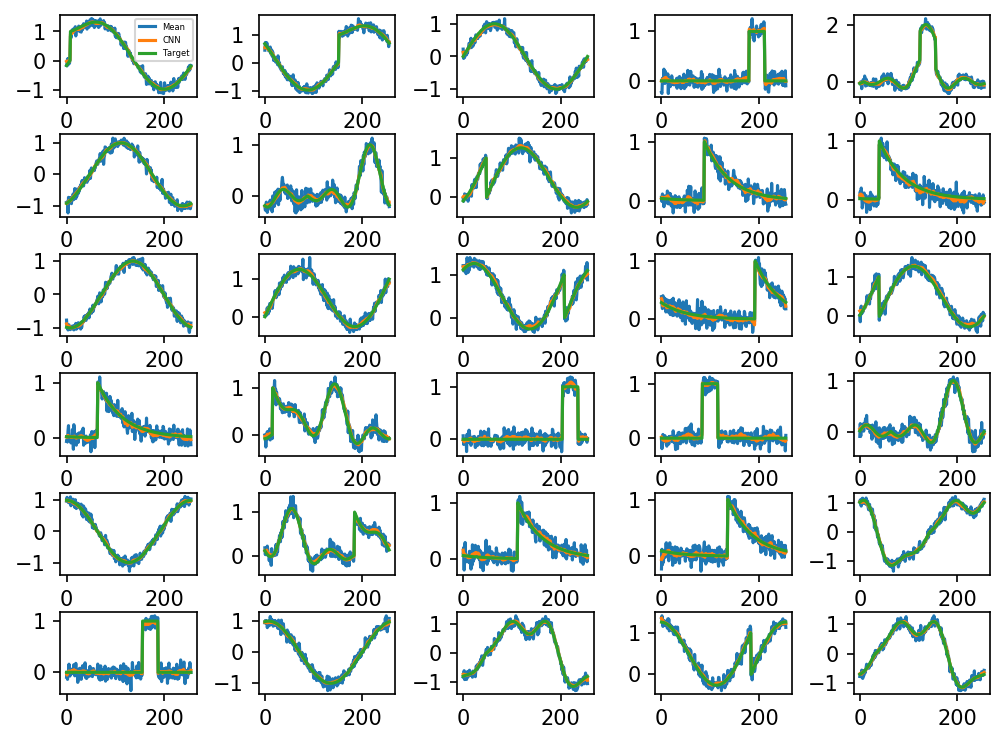

In [9]:
# Displaying some prediction results
plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(6, 5)
gs1.update(wspace=0.45, hspace=0.45)

test_unorm = test*norm_std + norm_mean
for ii in range(30):
    plt.subplot(gs1[ii])
    plt.plot(test_unorm[ii].mean(axis = -1).T,label = 'Mean')
    plt.plot(pred[ii,:,0],label = 'CNN')
    plt.plot(test_target[ii].T, label = "Target")
    if (ii == 0):
        plt.legend(fontsize = 4)
plt.show()

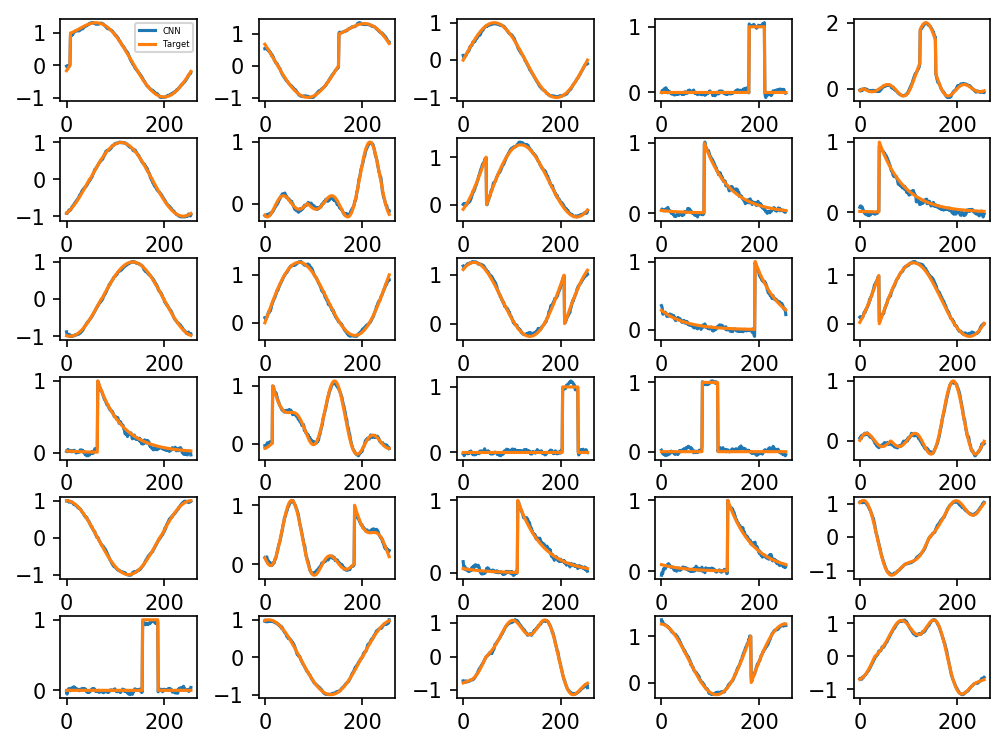

In [10]:
# Displaying some prediction results
plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(6, 5)
gs1.update(wspace=0.45, hspace=0.45)

test_unorm = test*norm_std + norm_mean
for ii in range(30):
    plt.subplot(gs1[ii])
    plt.plot(pred[ii,:,0],label = 'CNN')
    plt.plot(test_target[ii].T, label = "Target")
    if (ii == 0):
        plt.legend(fontsize = 4)
plt.show()